In this notebook, I have trained a machine learning model to predict potential loan defaulters.

1. Data Prepocessing
2. Training ML Model
3. Evaluating Model on Test Data
4. Learning Cuvre and Scope for Improvement

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p     
import joblib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Importing custom classes and functions
from lending_club.data_cleaning import *

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve,StratifiedKFold

In [3]:
def create_performance_chart(data,y_pred,y_test):
    picked=data.loc[y_pred==0]
    grades=['A','B','C','D','E','F','G']
    tmp=pd.DataFrame(columns=['ROI','% Picked','% Default'],index=grades)
    for g in grades:
        grade_picked=picked[picked['grade']==g]
        if len(grade_picked.index)==0:
            roi=None
            default_rate=None
            perc_picked=0
        else:
            num_picked=len(grade_picked.index)
            num_total=len(data[data['grade']==g].index)
            roi=sum(grade_picked['total_pymnt'])/sum(grade_picked['funded_amnt'])-1
            l=y_test[list(grade_picked.index)]
            default_rate=100*len(l[l==1])/len(l)
            perc_picked=100*num_picked/num_total

        tmp.loc[g,'% Picked']=perc_picked
        tmp.loc[g,'ROI']=roi
        tmp.loc[g,'% Default']=default_rate
    return tmp

## Data Preprocessing

* Selected only Fully Paid and Defaulted loans for training model.
* Train-Test Split
* Created a pipeline for data preprocessing. See 'Data Cleaning' notebook for detailed approach.
* Standard Scaling
* Over-Sampling using SMOTE : I have not used this in final model, as ML models I have used consider class imbalance.
* I have not removed features with high VIF, as model is uderfitting and performing well after including these features.

In [4]:
data=pd.read_csv('loan.csv')

# Select only default or paid loans. Ignore current loans
default=['Charged Off','Late (31-120 days)','Default',
             'Does not meet the credit policy. Status:Charged Off','Late (16-30 days)',
                 'In Grace Period']
paid=['Fully Paid',
              'Does not meet the credit policy. Status:Fully Paid']

data['loan_status']=data['loan_status'].apply(lambda x: 'Default' if x in default else x)
data['loan_status']=data['loan_status'].apply(lambda x: 'Fully Paid' if x in paid else x)
data=data[(data['loan_status']=='Default') | (data['loan_status']=='Fully Paid')]
y=data['loan_status'].apply(lambda x: 1 if x=='Default' else 0)
data.drop('loan_status',axis=1,inplace=True)

In [5]:
# Train-Test Split (Stratified)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y,random_state=42)

In [6]:
# Creating pipeline for data preprocessing

selected_featues=['loan_amnt', 'term', 'int_rate',
                  'grade',#'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status','issue_d', 
        'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

num_features= ['loan_amnt', 'int_rate', 'emp_length','annual_inc',
       'dti','delinq_2yrs','inq_last_6mths','revol_bal', 'revol_util',
       'total_acc','open_acc','pub_rec','acc_now_delinq','tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

dummy_cols=['term','grade','home_ownership','verification_status','purpose']

states_to_keep=['FL','NY','LA','NV','IN','CA','IL','GA','TX']

features_to_scale=['loan_amnt', 'int_rate', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim']

pipeline=Pipeline([
    ('selector',DataFrameSelector(selected_featues)),
    ('misc_fe',Misc_Feature_Engineering()),
    ('total_rev_hi_lim_Imp',total_rev_hi_lim_Imputer()),
    ('median_imp',Median_Imputer(num_features)),
    ('dummy_vars',Dummy_Variables(states_to_keep=states_to_keep,cat_cols=dummy_cols)),
    ('tranform_features',Transform_Skewed_Features())
])

In [7]:
X_train=pipeline.fit_transform(X_train)

In [8]:
# Scaling
scaler=StandardScaler()
X_train[features_to_scale]=scaler.fit_transform(X_train[features_to_scale])

In [9]:
# Over-sampling
# columns=X_train.columns
# from imblearn.over_sampling import SMOTE
# smt=SMOTE(random_state=51,n_jobs=-1)
# X_train,y_train=smt.fit_sample(X_train,y_train)
# X_train=pd.DataFrame(X_train,columns=columns)

## Training Model

Models:
1. Logistic Regression
2. Random Forest
3. LightGBM

Final Model:
* Hard voting of above three models (Defaulter if all three models predict as defaulter)

In [10]:
# Linear Regression
lr=LogisticRegression(C=10,tol=0.0001,random_state=51,n_jobs=-1,solver='liblinear',class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=51,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
# Random Forest
rfc=RandomForestClassifier(n_estimators=150,max_depth=14,max_leaf_nodes= None, 
                           min_impurity_decrease= 1e-05, min_samples_leaf= 100,
                           class_weight='balanced',n_jobs=-1,random_state=51)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=1e-05,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False, random_state=51,
            verbose=0, warm_start=False)

In [12]:
# LGBM
lgb=LGBMClassifier(random_state=51, class_weight= {0: 1, 1: 4}, colsample_bytree=1, max_depth=7,
 min_child_samples=20, min_split_gain=0, n_estimators=100, reg_alpha=13)
lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 4},
        colsample_bytree=1, importance_type='split', learning_rate=0.1,
        max_depth=7, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=51, reg_alpha=13, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

## Predicting on Test Data

In [13]:
# Preprocessing Test Data
X_test_1=X_test.copy()
X_test=pipeline.transform(X_test)
X_test[features_to_scale]=scaler.transform(X_test[features_to_scale])

In [14]:
# Linear Regression
y_test_pred_lr=lr.predict(X_test)

# Random Forest
y_test_pred_rfc=rfc.predict(X_test)

# LightGBM
y_test_pred_lgb=lgb.predict(X_test)

In [15]:
# Voting
result=pd.DataFrame(index=X_test.index)
result['lr']=y_test_pred_lr
result['rfc']=y_test_pred_rfc
result['lgb']=y_test_pred_lgb
result['count']=result.sum(axis=1)
result['y_pred']=result['count'].apply(lambda x: 1 if x>=3 else 0)
result['y']=y_test

In [16]:
print(classification_report(y_test,result['y_pred']))
print('ROC-AUC:',round(roc_auc_score(y_test,result['y_pred']),4))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77     41942
           1       0.40      0.61      0.48     13486

   micro avg       0.68      0.68      0.68     55428
   macro avg       0.62      0.66      0.62     55428
weighted avg       0.74      0.68      0.70     55428

ROC-AUC: 0.655


## Evaluating Model (On Test Set)

**Model is able to predict 61% of the defaulters.**

Let us look at **Return on investment (ROI)** to see how model can help in real business.
To calculate ROI, I've used total loan repayed and amount funded as loan. These variables leak future information and I have not used these variables for training. Data used to calculate ROI includes fully paid, charged off and loans in grace period. It does not include Current loans.

**ROI = 'total_payment' / 'funded_amount'**

**ROI without using model : -4.57**

**ROI after using model : 2.22**

### Grade-wise Analysis of ROI:
A table below shows grade-wise analysis of loans. It shows ROI, % of loans selected and % of loans defaulted from selected loans.

* ROI for every grade has improved.
* ROI for grades C, D, E, G became positive after using model.


Text(33,0.5,'Predicted Label')

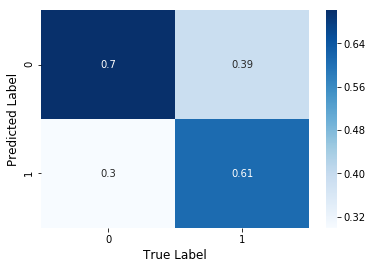

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, result['y_pred']).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

In [18]:
# Improvement in ROI after using model

index=result[result['y_pred']==0].index
tmp=X_test_1.loc[index][['total_pymnt','funded_amnt']]
roi=(tmp['total_pymnt'].sum()/tmp['funded_amnt'].sum()-1)*100
print("ROI after filtering potential defaulters:",round(roi,2))

tmp=X_test_1[['total_pymnt','funded_amnt']]
roi=(tmp['total_pymnt'].sum()/tmp['funded_amnt'].sum()-1)*100
print("ROI without filtering defaulters:",round(roi,2))

ROI after filtering potential defaulters: 2.22
ROI without filtering defaulters: -4.57


In [19]:
# Grade-wise ROI
df1=create_performance_chart(X_test_1,result['y_pred'],y_test)
df2=create_performance_chart(X_test_1,np.zeros(len(y_test)),y_test)
df2.columns=map(lambda x:x+'_w/o_model',df2.columns)
pd.concat([df1,df2],axis=1)

,ROI,% Picked,% Default,ROI_w/o_model,% Picked_w/o_model,% Default_w/o_model
A,0.0250712,99.9774,8.64002,0.025071,100,8.63806
B,0.0200738,96.1866,16.1057,0.0152713,100,16.7564
C,0.017765,53.9985,18.7983,-0.0447373,100,25.9779
D,0.0349775,24.597,20.8825,-0.096151,100,34.7948
E,0.0703003,7.08117,22.2561,-0.143831,100,42.5518
F,-0.0234227,3.26508,22.0339,-0.16447,100,47.316
G,0.0961287,2.6694,38.4615,-0.163535,100,50.1027


## Learning Curve and Scope for Improvement

From learning curve, it is clear that model is the underfit. Even if we supply more data, it will improve model minimally.

Also confusion matrix printed above shows that 30% of the fair loans were predicted as default.

This model can be improved by adding more features.

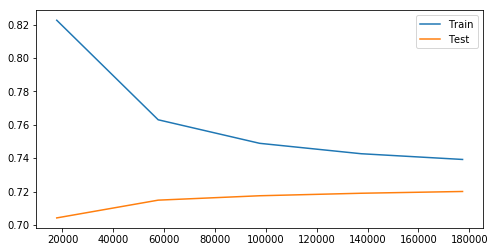

In [20]:
#learning curve
lgb=LGBMClassifier(random_state=51, class_weight= {0: 1, 1: 4}, colsample_bytree=1, max_depth=7,
 min_child_samples=20, min_split_gain=0, n_estimators=100, reg_alpha=13)

lc=learning_curve(lgb,X_train,y_train,cv=StratifiedKFold(random_state=51,n_splits=5),scoring='roc_auc',
                  n_jobs=1,random_state=51)
size=lc[0]
train_score=[lc[1][i].mean() for i in range (0,5)]
test_score=[lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(8,4))
plt.plot(size,train_score,label='Train')
plt.plot(size,test_score,label="Test")
plt.legend()